# XRF Core Scan Processing and Calibration: IODP Site U1474
Daniel Babin$^1$, Sidney Hemming$^1$, Allison Franzese$^{1,2}$, and Luis Tejada$^{1,2}$ <br>
1. Lamont Doherty Earth Observatory, 61 Rte 9W, Palisades, NY 10964 <br>
2. Hostos Community College, 450 Grand Concourse, The Bronx, NY 10451 <br>

An essentially continuous record of sediment chemistry at U1474 is available in the form of XRF core scan data, collected on an Itrax Core Scanner in the Core Repository at Lamont-Doherty Earth Observatory. This technique bombards the surface of the core with X-rays, and the resulting spectra measured yields relative abundance of elements. At 30 kV and 55 mA settings, measurements were applied at 2 mm intervals with an exposure time of 2 seconds along the 252 m length of each core in the U1474 splice using a Cr tube. Due to shipping error, one core (U1474E 17; Sections 1-3) did not reach Lamont-Doherty Earth Observatory. <br>

We will import the XRF data as a dataframe using pandas. The data takes the form of "counts," or relative abundances, of elements at 2 mm depth intervals along the 255 m long length of the core "Splice." Also included in the raw data are descriptive information about the Site and Expedition, as well as information about machine settings during scanning. I list the columns below.

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import interpolate
from scipy import signal
from scipy import stats
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

# Make Data Path and Figure Path
These are "input" and "output" paths for the program to read and write data.

In [69]:
data_path='/Users/danielbabin/Documents/GitHub/XRF_Data_Report/Data/'
figure_path='/Users/danielbabin/Documents/GitHub/XRF_Data_Report/Figures/'
table_path='/Users/danielbabin/Documents/GitHub/XRF_Data_Report/Tables/'

# Import XRF Data

In [70]:
xrf=pd.read_csv(data_path+'U1474_XRF_Splice rereduced.csv',
                low_memory=False,index_col='Depth CCSF (m)')
xrf.to_csv(table_path+'raw_xrf_data.csv')

# Manipulate XRF Data
Here in this section will be the bulk of our data cleaning and preparation
## Clean the XRF Data
We would like to make a dataframe that has exactly the information we'd like to manipulate: high quality data of elements at depth.
### Drop measurements at depths not in the "Splice"
The raw data contains every measurement we made on every section of the core. IODP takes long cores from many different, nearby holes at a site, which tend to be incomplete. However, these cores can be correlated to form a continuous record, called the splice. Because these correlations could occur at any depth in the core, at which point we might transition to another core, some measurements we took are not in the splice. We need to drop those.

In [71]:
xrf=xrf[xrf['In the Splice?']==True]
xrf=xrf.sort_index().copy()
xrf=xrf[~xrf.index.duplicated(keep='first')].copy()

### Give Each Section a Unique Identifier

In [72]:
xrf['section_ID']=(xrf['Hole'].map(str) + xrf['Core'].map(str) + 
                   xrf['Type'].map(str) + xrf['Section'].map(str))

### Visualize Complete XRF Dataset

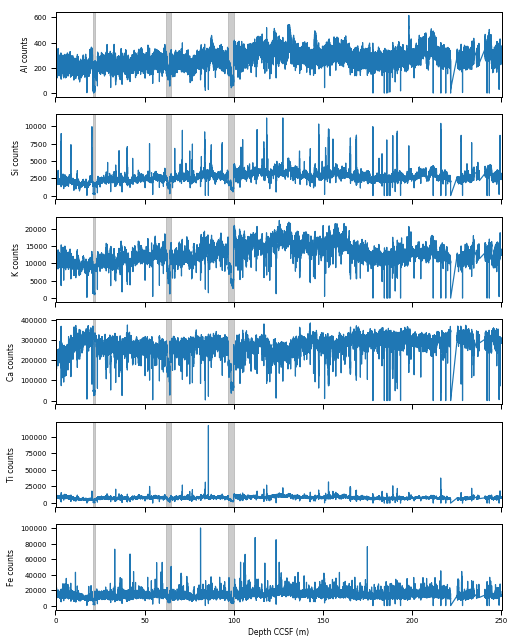

In [73]:
fig,ax=plt.subplots(nrows=6,figsize=(8,11),sharex=True)
for i,e in enumerate(['Al','Si','K','Ca','Ti','Fe']):
    xrf[e].plot(ax=ax[i])
    ax[i].axvspan(xmin=21,xmax=22,color='k',alpha=.2)
    ax[i].axvspan(xmin=62,xmax=65,color='k',alpha=.2)
    ax[i].axvspan(xmin=97,xmax=100,color='k',alpha=.2)
    ax[i].set_ylabel(e+' counts')

Notice the sections highlighted in grey have relatively low counts. Checking the raw data reveals they were scanned at low amperage.

### Investigate Problem Sections

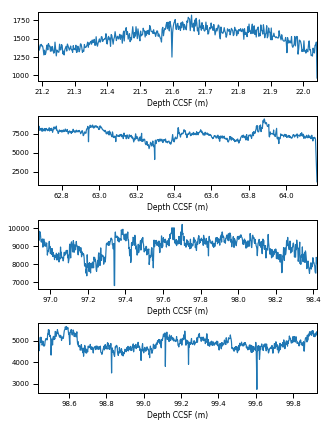

In [74]:
fig,axes=plt.subplots(nrows=4,figsize=(5,7))
xrf[xrf['section_ID']=='D4H1']['K'].plot(ax=axes[0])
xrf[xrf['section_ID']=='D8H3']['K'].plot(ax=axes[1])
xrf[xrf['section_ID']=='D11H4']['K'].plot(ax=axes[2])
xrf[xrf['section_ID']=='D11H5']['K'].plot(ax=axes[3])
plt.subplots_adjust(hspace=.5)

### Repair Sections
It seems as if multiplying each of the 4 sections by a scalar, different for each section but identical for all 6 elements, does a relatively good job fixing the counts. Aluminum is an exception. Counts for aluminum are relatively low, and thus the signal/noise ratio is low. Scaling the elements should not affect ratios, commonly used for XRF core scanning, so this manipulation might not matter much. <br> <br> Additionally, we repair the quantity reflecting the degree of cohesive scatter ("Cr coh"), because we found that normalizing terrigenously derived elements (K,Fe,Ti), to this factor improves the correlation with the calibration samples. This is shown later. <br> <br> Here we show how we scaled each mis-scanned section:

In [75]:
repaired_xrf=xrf.copy()

In [76]:
e_list=['Al','Si','K','Ca','Ti','Fe']

#### Section D4H1

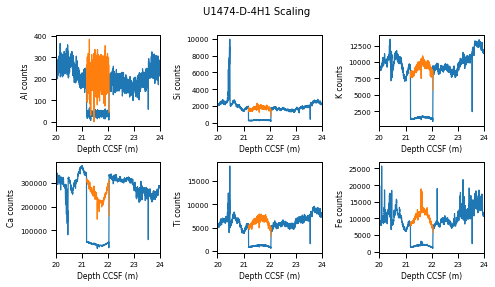

In [77]:
scalar=6
ids=xrf[xrf['section_ID'] == 'D4H1'].index
fig1,ax1=plt.subplots(ncols=3,nrows=2,figsize=(7,4))
for i,e in enumerate(e_list):
    ax=plt.subplot(2,3,i+1)
    xrf[e].loc[20:24].plot(ax=ax)
    (xrf[xrf['section_ID'] == 'D4H1'][e]*scalar).plot(ax=ax)
    ax.set_ylabel(e+' counts')
repaired_xrf.loc[ids,e_list]=(xrf[xrf['section_ID'] == 'D4H1'][e_list]*scalar)
plt.suptitle('U1474-D-4H1 Scaling',size=10)
plt.subplots_adjust(hspace=.4,wspace=.55,right=.95,left=.1)
fig1.savefig(figure_path+'repair1.png',dpi=500)

### Section D8H3

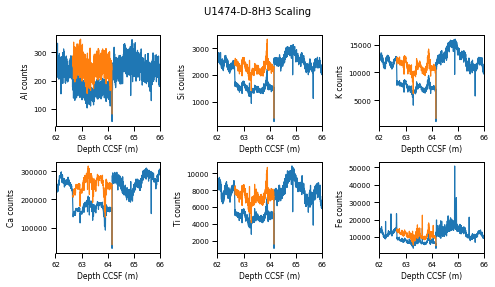

In [78]:
scalar=1.5
ids=xrf[xrf['section_ID'] == 'D8H3'].index
fig2,ax2=plt.subplots(ncols=3,nrows=2,figsize=(7,4))
for i,e in enumerate(e_list):
    ax=plt.subplot(2,3,i+1)
    xrf[e].loc[62:66].plot(ax=ax)
    ((xrf[xrf['section_ID'] == 'D8H3'][e])*scalar).plot(ax=ax)
    ax.set_ylabel(e+' counts')
plt.suptitle('U1474-D-8H3 Scaling',size=10)
plt.subplots_adjust(hspace=.4,wspace=.55,right=.95,left=.1)
fig2.savefig(figure_path+'repair2.png',dpi=500)
repaired_xrf.loc[ids,e_list]=(xrf[xrf['section_ID'] == 'D8H3'][e_list]*scalar)

### Sections D11H4 and D11H5

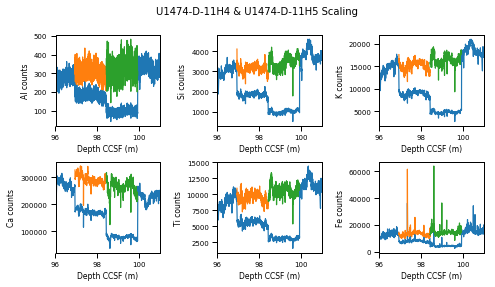

In [79]:
scalar1=1.7
scalar2=3.4
ids=xrf[xrf['section_ID'] == 'D11H4'].index
fig3,ax3=plt.subplots(ncols=3,nrows=2,figsize=(7,4))
for i,e in enumerate(e_list):
#     ax=plt.subplot(2,3,i+1)
    xrf[e].loc[96:101].plot(ax=ax3[(int(i/3),i%3)])
    (xrf[xrf['section_ID'] == 'D11H4'][e]*scalar1).plot(ax=ax3[(int(i/3),i%3)])
    ids=xrf[xrf['section_ID'] == 'D11H5'].index
    (xrf[xrf['section_ID'] == 'D11H5'][e]*scalar2).plot(ax=ax3[(int(i/3),i%3)])
    ax3[(int(i/3),i%3)].set_ylabel(e+' counts')
#     ax3[int(i/3)][int(i/2)]=ax
plt.suptitle('U1474-D-11H4 & U1474-D-11H5 Scaling',size=10)
plt.subplots_adjust(hspace=.4,wspace=.55,right=.95,left=.1)
fig3.savefig(figure_path+'repair3.png',dpi=500)

ids=xrf[xrf['section_ID'] == 'D11H4'].index
repaired_xrf.loc[ids,e_list]=(xrf[xrf['section_ID'] == 'D11H4'][e_list]*scalar1)
ids=xrf[xrf['section_ID'] == 'D11H5'].index
repaired_xrf.loc[ids,e_list]=(xrf[xrf['section_ID'] == 'D11H5'][e_list]*scalar2)


### Repaired Data

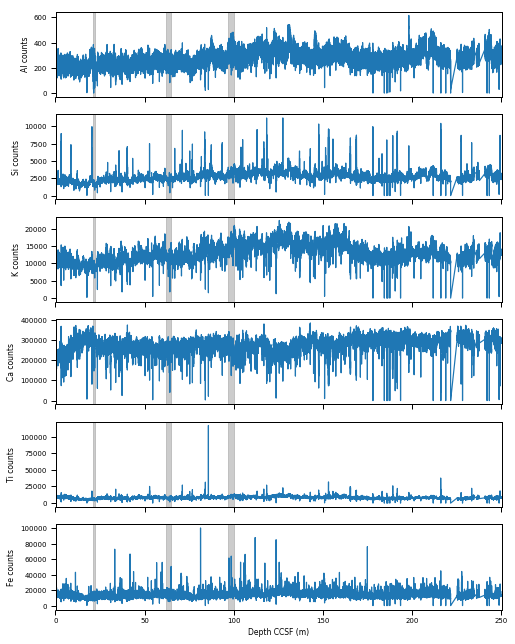

In [80]:
fig,ax=plt.subplots(nrows=6,figsize=(8,11),sharex=True)
for i,e in enumerate(e_list):
    repaired_xrf[e].plot(ax=ax[i])
    ax[i].axvspan(xmin=21,xmax=22,color='k',alpha=.2)
    ax[i].axvspan(xmin=62,xmax=65,color='k',alpha=.2)
    ax[i].axvspan(xmin=97,xmax=100,color='k',alpha=.2)
    ax[i].set_ylabel(e+' counts')

### Drop rows where any major elemental datum = 0
There are some rows where the counts are 0. These measurements would likely reflect cracks in the core, or the ends of cores. We would like to drop from the dataframe

In [81]:
clean_zeroless_xrf=repaired_xrf.copy()
clean_zeroless_xrf=repaired_xrf[(repaired_xrf[['Al','Si','K','Ca','Ti','Fe']] != 0).all(1)]

### Check the MSE to ensure good data
"MSE" provides an estimate of the quality of fit the ITRAX program Q-spec was able replicate the returned spectra from the x-ray bombardment with a spectral model, which it can convert to elements.

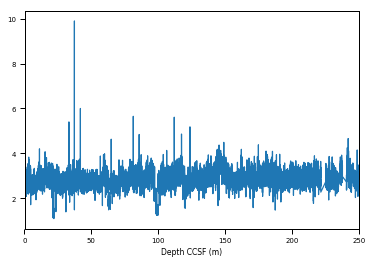

In [82]:
clean_zeroless_xrf['MSE'].plot()

No long sections have anomalously high MSE, which would be expected for a problematic section

### Sort by depth, delete duplicates, and save "cleaned" raw data
Saving the clean raw data now will allow other scientists, interested in reanalyzing my data, to have it in its most basic form

In [83]:
clean_zeroless_xrf = clean_zeroless_xrf[~clean_zeroless_xrf.index.duplicated(keep='first')].copy()
clean_zeroless_xrf=clean_zeroless_xrf.sort_index().copy()
clean_zeroless_xrf.to_csv(table_path+'xrf_counts_repaired_sections_zeroes_dropped.csv')

## Check Quality of Raw XRF Data
It is common to calibrate X-Ray Flourescense data with well constrained concentration data. Here we provide elemental flux fusion concentrations of discrete sediment samples at different core depths for our calibration.
At this point, we can assess the quality of our raw data by comparing the xrf counts, relative abundances, to absolute concentrations from our calibration dataset
### Import Calibration Dataset

In [84]:
reference_conc_raw=pd.read_csv(data_path+'mad_samples_bulk.csv',index_col='Depth')

Select elements we want

In [85]:
reference_conc=reference_conc_raw[['Al','Si','K','Ca','Ti','Fe']]
reference_conc.to_csv(table_path+'calibration_samples_concentrations.csv')

### Prepare "Counts" dataframe for comparison
We need to make an dataframe of xrf counts identical in size to the calibration data (reference_conc), extracted from the xrf counts dataframe at the depth of the calibration samples. This way, we can directly compare counts at a depth to concentration at a depth.
<br> cts_check will be this dataframe. Right now it is empty.

In [86]:
cts_check=pd.DataFrame(columns=reference_conc.columns)

Here we first make a dataframe of just the elements we want from the clean xrf data. We then sort through this dataframe to find the depths of the calibration samples, and then add those measurements to the dataframe "cts_check"

In [87]:
xrf_check=clean_zeroless_xrf[reference_conc.columns]
for i in reference_conc.index:
    idx=xrf_check.index.get_loc(i,method='nearest')
    cts_check.loc[xrf_check.iloc[idx].name]=xrf_check.iloc[idx]

Both dataframes are made, the identical in size, and ready for comparison

In [88]:
reference_conc.shape

(23, 6)

In [89]:
cts_check.shape

(23, 6)

### Define function r2 to assess correlation

In [90]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

### Compare raw data and calibration data to assess quality

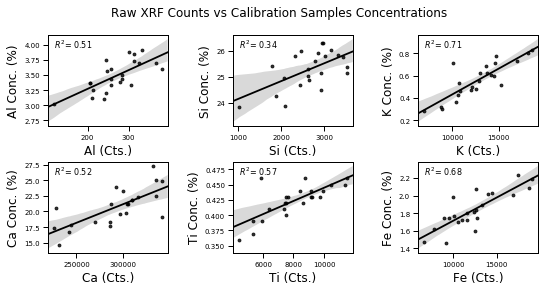

In [91]:
fig,axes=plt.subplots(ncols=3,nrows=2,figsize=(8,4))
for i,col in enumerate(reference_conc.columns):
    ax=plt.subplot(2,3,i+1)
    sns.regplot(cts_check[col],reference_conc[col],color='k',ax=ax,scatter_kws={'s':8})
    text=str('$R^2$= '+r2(cts_check[col],reference_conc[col]).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel(col+' Conc. (%)',size=12)
    ax.set_xlabel(col+' (Cts.)',size=12)
plt.suptitle('Raw XRF Counts vs Calibration Samples Concentrations',size=12)
plt.subplots_adjust(hspace=.4,wspace=.55,right=.95,left=.1)
fig.savefig(figure_path+'1xrf_raw_vs_calibration.png',dpi=500)

It seems even our raw xrf data, prior to processing, is okay. Relative abunances reliably predict concentration

## Normalize XRF Data
The ITRAX is capable of measuring a wide array of elements, from light major elements like Aluminum to heavy trace elements like Neodymium. However, trace elements are far less reliable, requiring longer measurement times and careful calibration. 
<br> Water content varies downcore. This can have the effect of diluting counts of other elements geologists might be interested in.
<br> These factors combined make normalizing xrf data to total counts a common practice. Here we normalize our xrf data to the total counts of the major elements we are interested in. 
### Normalize by counts

In [25]:
total_cts=clean_zeroless_xrf[['Al','Si','K','Ca','Ti','Fe']].sum(axis=1)
normed_elems=(clean_zeroless_xrf[['Al','Si','K','Ca','Ti','Fe']]
              .div(total_cts,axis=0)
              .mul(total_cts.mean(),axis=0).dropna())

Below we check the effect of our normalization on the comparison to our calibration dataset. We will do this many times, so I have combined and automated the depth extraction and plotting function into a function called "compare"

### Define Compare

In [26]:
def compare(input_df,im_name,suptitle):
    cts_check=pd.DataFrame(columns=reference_conc.columns)
    xrf_check=input_df
    for i in reference_conc.index:
        idx=xrf_check.index.get_loc(i,method='nearest')
        cts_check.loc[xrf_check.iloc[idx].name]=xrf_check.iloc[idx]
    fig,axes=plt.subplots(ncols=3,nrows=2,figsize=(8,4))
    for i,col in enumerate(reference_conc.columns):
        ax=plt.subplot(2,3,i+1)
        sns.regplot(cts_check[col],reference_conc[col],color='k',ax=ax,scatter_kws={'s':8})
        text=str('$R^2$= '+r2(cts_check[col],reference_conc[col]).astype(str)[:4])
        ax.text(0.05, .97, text,
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes, fontsize=8)
        ax.set_ylabel(col+' Conc. (%)',size=12)
        ax.set_xlabel(col+' (Cts.)',size=12)
    plt.suptitle(suptitle,size=12)
    plt.subplots_adjust(hspace=.4,wspace=.55,right=.95,left=.1)
    fig.savefig(figure_path+im_name)

### Compare Normalized data and calibration

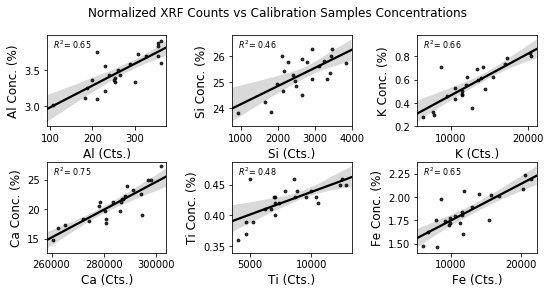

In [27]:
compare(normed_elems,'2normed_xrf_vs_calibration.png','Normalized XRF Counts vs Calibration Samples Concentrations')

### Compare Normalized data and raw data

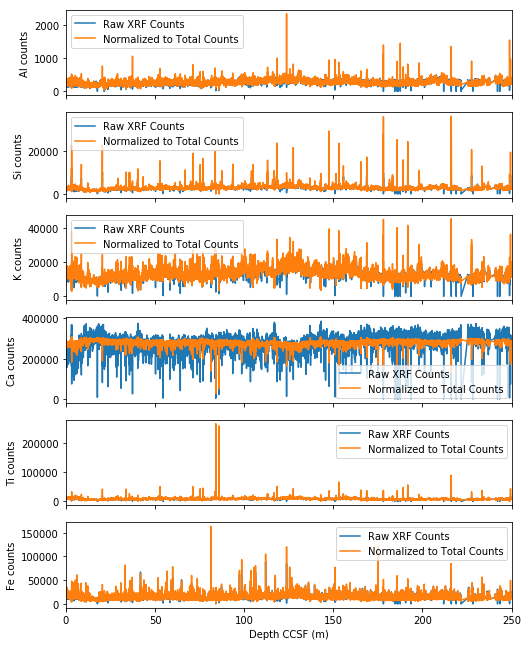

In [28]:
fig,ax=plt.subplots(nrows=6,figsize=(8,11),sharex=True)
for i,e in enumerate(['Al','Si','K','Ca','Ti','Fe']):
    repaired_xrf[e].plot(ax=ax[i],label='Raw XRF Counts')
    normed_elems[e].plot(ax=ax[i],label='Normalized to Total Counts')
    ax[i].set_ylabel(e+' counts')
    ax[i].legend()

In [29]:
normed_elems.to_csv(table_path+'xrf_counts_normalized_to_total_counts.csv')

## Apply an outlier remover function
Grant et al. (2017, A 3 million year index for North African humidity/aridity and the implication of potential pan-African Humid periods, _Quaterary Science Reviews_, https://doi.org/10.1016/j.quascirev.2017.07.005) uses an isometric log ratio transformation and mahalanobis distance to remove outliers from their XRF core scan dataset. However, the code is in Matlab. So if you want to run this code in python: <br>

Open an anaconda terminal and change to the directory: "matlabroot\extern\engines\python" <br>
Run setup.py file: python setup.py install<br><br>
Link to Mathworks website with info on installation: <br>
https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html

### Activate Matlab Engine

In [30]:
import matlab.engine
eng = matlab.engine.start_matlab()

### Convert dataframe into form usable by matlab

In [31]:
data=normed_elems[['Al','Si','K','Ca','Ti','Fe']]

In [32]:
matlab_compatible_matrix=np.c_[data.index.values,data.values]

In [33]:
mat_ML = matlab.double(matlab_compatible_matrix.tolist())

### Apply outlier removal function
The 2 arguement to this function represents > 2$\sigma$ deviation of the mahalanobis distance from the mean mahalanobis distance

In [34]:
cleaned_ML=eng.apply_cutoff(mat_ML,2)

### Convert back into python data

In [35]:
cleaned=np.array(cleaned_ML._data.tolist())

In [36]:
row_num=int(cleaned.shape[0]/8)
cleaned=cleaned.reshape(8,row_num).transpose()
cleaned=pd.DataFrame(cleaned,columns=['Depth (m)','Al', 'Si', 'K', 'Ca', 'Ti', 'Fe','d1'])
cleaned=cleaned.set_index('Depth (m)')

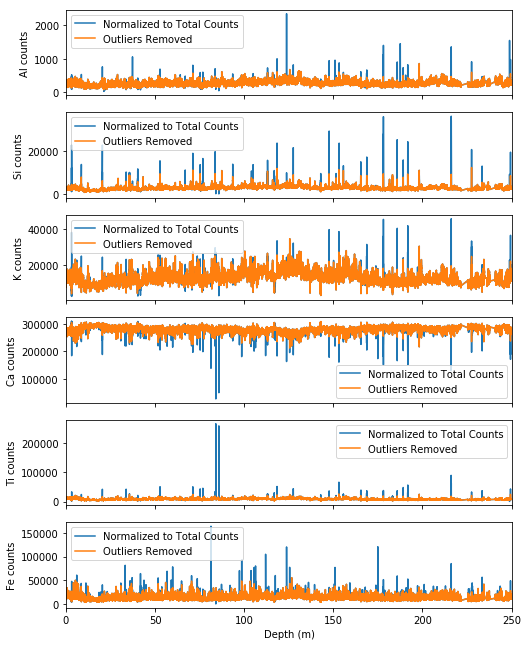

In [37]:
fig,ax=plt.subplots(nrows=6,figsize=(8,11),sharex=True)
for i,e in enumerate(['Al','Si','K','Ca','Ti','Fe']):
    data[e].plot(ax=ax[i],label='Normalized to Total Counts')
    cleaned[e].plot(ax=ax[i],label='Outliers Removed')
    ax[i].legend()
    ax[i].set_ylabel(e+' counts')

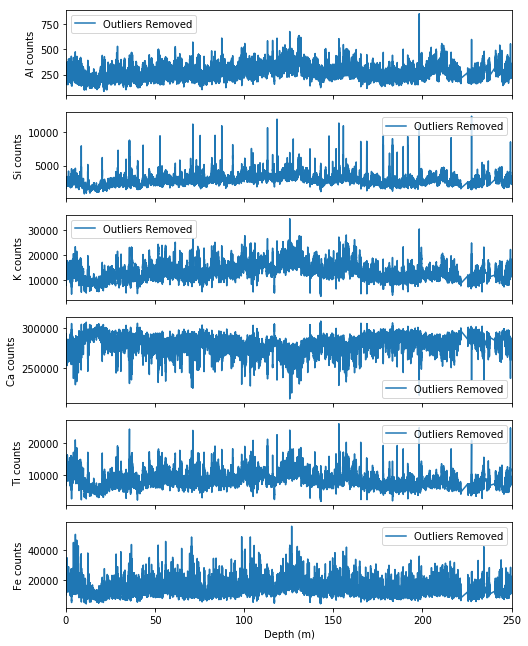

In [38]:
fig,ax=plt.subplots(nrows=6,figsize=(8,11),sharex=True)
for i,e in enumerate(['Al','Si','K','Ca','Ti','Fe']):
    cleaned[e].plot(ax=ax[i],label='Outliers Removed')
    ax[i].legend()
    ax[i].set_ylabel(e+' counts')

### Compare cleaned data and calibration

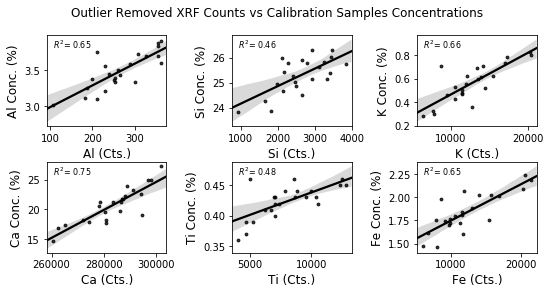

In [39]:
compare(cleaned,'3cleaned_vs_calibration.png','Outlier Removed XRF Counts vs Calibration Samples Concentrations')

In [40]:
cleaned.to_csv(table_path+'xrf_counts_outliers_removed.csv')

## Integrate data in 2 cm increments
The original plan with the XRF core scan was to have the data output at 2 cm intervals. We however discovered that regardless, the machine makes measurements at 2 mm interval. If we selected a 2 cm output, the machine would sum/average 10 measurements for us. So we chose to get the raw data, and perform the calculation ourselves. 

This sort of data manipulation is called a boxcar filter, where every point in the filter has equal weight. 
### Make a 10 pt boxcar window

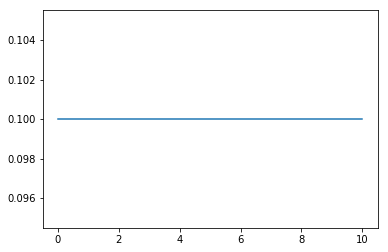

In [41]:
box=signal.boxcar(10)
box=box/sum(box)
fig,ax=plt.subplots()
ax.plot(np.linspace(0,10,10),box)

### Apply Filter

In [42]:
box_filt=cleaned.rolling(10,min_periods=10,center=True).apply(func=lambda x: np.dot(box,x),raw=True).dropna()

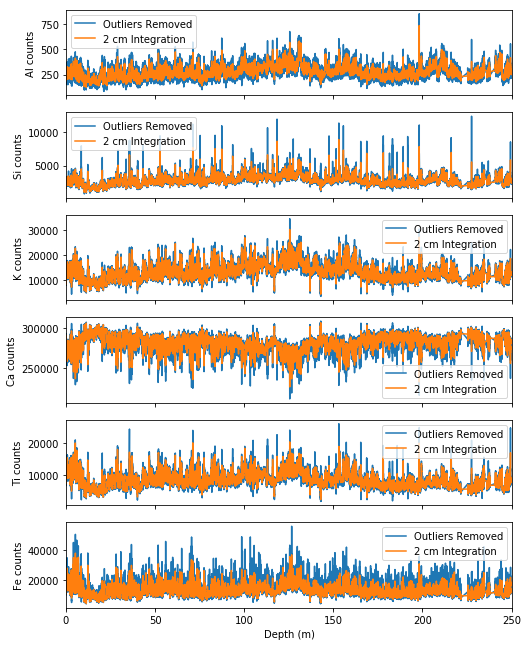

In [43]:
fig,ax=plt.subplots(nrows=6,figsize=(8,11),sharex=True)
for i,e in enumerate(['Al','Si','K','Ca','Ti','Fe']):
    cleaned[e].plot(ax=ax[i],label='Outliers Removed')
    box_filt[e].plot(ax=ax[i],label='2 cm Integration')
    ax[i].legend()
    ax[i].set_ylabel(e+' counts')

### Save filtered results

In [44]:
box_filt.to_csv(table_path+'xrf_counts_2cm_smoothed.csv')

### Compare smoothed data to calibration

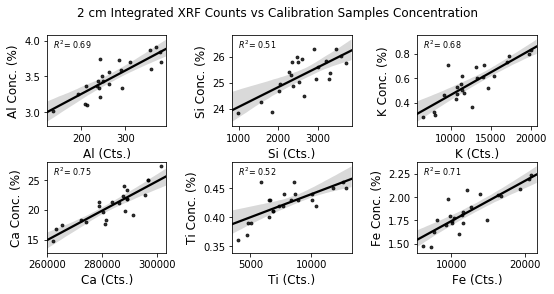

In [45]:
compare(box_filt,'4filtered_vs_calibration.png','2 cm Integrated XRF Counts vs Calibration Samples Concentration')

## Convert counts to concentrations
We convert xrf counts, relative abundance, to absolute concentrations using the procedure of Weltje et al. (2008, Calibration of XRF core scanners for quantitative geochemical logging of sediment cores: Theory and application, _Earth and Planetary Science Letters_, https://doi.org/10.1016/j.epsl.2008.07.054). The procedure uses a Univariate log-ratio calibration. In our dataset, we compare all elements to Ca, as recommended by Weltje et al.

### Create dataframe of ratios from XRF core scans

In [46]:
box_filt_ratios=pd.DataFrame(index=box_filt.index)
box_filt_ratios['Al/Ca']=box_filt['Al']/box_filt['Ca']
box_filt_ratios['Si/Ca']=box_filt['Si']/box_filt['Ca']
box_filt_ratios['K/Ca']=box_filt['K']/box_filt['Ca']
box_filt_ratios['Ca/Ca']=box_filt['Ca']/box_filt['Ca']
box_filt_ratios['Ti/Ca']=box_filt['Ti']/box_filt['Ca']
box_filt_ratios['Fe/Ca']=box_filt['Fe']/box_filt['Ca']

### Create dataframe of ratios from Flux Fusion Calibration Dataset

In [47]:
ref_conc_ratios=pd.DataFrame(index=reference_conc.index)
ref_conc_ratios['Al/Ca']=reference_conc['Al']/reference_conc['Ca']
ref_conc_ratios['Si/Ca']=reference_conc['Si']/reference_conc['Ca']
ref_conc_ratios['K/Ca']=reference_conc['K']/reference_conc['Ca']
ref_conc_ratios['Ca/Ca']=reference_conc['Ca']/reference_conc['Ca']
ref_conc_ratios['Ti/Ca']=reference_conc['Ti']/reference_conc['Ca']
ref_conc_ratios['Fe/Ca']=reference_conc['Fe']/reference_conc['Ca']

### Extract XRF core scan ratio at depth of calibrations samples
First extract counts at depth

In [48]:
cts_check=pd.DataFrame(columns=reference_conc.columns)

for i in reference_conc.index:
    idx=box_filt.index.get_loc(i,method='nearest')
    cts_check.loc[box_filt.iloc[idx].name]=box_filt.iloc[idx].copy()

model = [stats.linregress(cts_check[i],reference_conc[i]) for i in reference_conc.columns]

In [49]:
cts_check_ratios=pd.DataFrame(index=cts_check.index)
cts_check_ratios['Al/Ca']=cts_check['Al']/cts_check['Ca']
cts_check_ratios['Si/Ca']=cts_check['Si']/cts_check['Ca']
cts_check_ratios['K/Ca']=cts_check['K']/cts_check['Ca']
cts_check_ratios['Ca/Ca']=cts_check['Ca']/cts_check['Ca']
cts_check_ratios['Ti/Ca']=cts_check['Ti']/cts_check['Ca']
cts_check_ratios['Fe/Ca']=cts_check['Fe']/cts_check['Ca']

### Parameter Estimation
These are the parameters of the univariate log-ratio calibration of Weltje et al. 2008, as described in the supplementary information.

In [50]:
yis={}
for ratio in ref_conc_ratios.columns:
    yis[ratio]=np.array([np.log(ref_conc_ratios[ratio]),np.log(cts_check_ratios[ratio])]).transpose()
    
y_bars={}
for ratio in ref_conc_ratios.columns:
    y_bars[ratio]=np.array([yis[ratio][:,0].mean(),yis[ratio][:,1].mean()])
    
xis={}
for ratio in ref_conc_ratios.columns:
    xis[ratio]=np.array([yis[ratio][:,0]-y_bars[ratio][0],yis[ratio][:,1]-y_bars[ratio][1]]).transpose()
    
xtxs={}
for ratio in ref_conc_ratios.columns:
    xtxs[ratio]=np.dot(xis[ratio].transpose(),xis[ratio])

Fs={}
for ratio in ref_conc_ratios.columns:
    Fs[ratio]=(xtxs[ratio][0,0]-xtxs[ratio][1,1])/(2*xtxs[ratio][1,0])

Gs={}
for ratio in ref_conc_ratios.columns:
    Gs[ratio]=Fs[ratio]+np.sqrt(np.square(Fs[ratio])+1)

a_s={}
for ratio in ref_conc_ratios.columns:
    a_s[ratio]=Gs[ratio]/(np.sqrt(Gs[ratio])+1)
    
b_s={}
for ratio in ref_conc_ratios.columns:
    b_s[ratio]=1/(np.sqrt(Gs[ratio])+1)

alphas={}
for ratio in ref_conc_ratios.columns:
    alphas[ratio]=a_s[ratio]/b_s[ratio]
betas={}
for ratio in ref_conc_ratios.columns:
    betas[ratio]=y_bars[ratio][0]-alphas[ratio]*y_bars[ratio][1]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


### Calibrate XRF Scans

In [51]:
ln_wij_over_wid_xrf={}
for ratio in ref_conc_ratios.columns:
    ln_wij_over_wid_xrf[ratio]=alphas[ratio]*np.log(box_filt_ratios[ratio])+betas[ratio]

### Calibrate XRF data at calibration sample depths

In [52]:
ln_wij_over_wid_calibration={}
for ratio in ref_conc_ratios.columns:
    ln_wij_over_wid_calibration[ratio]=alphas[ratio]*np.log(cts_check_ratios[ratio])+betas[ratio]

### Here's a script that examines the correlation between calibrated xrf data and calibration sample concentrations

Text(0.1, 0.9, '0.86')

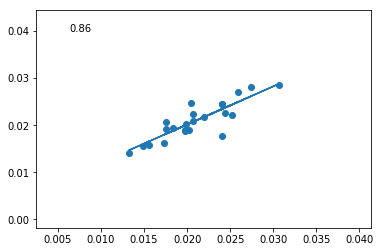

In [53]:
fig,ax=plt.subplots()
ratio='Ti/Ca'
ax.scatter(ref_conc_ratios[ratio],np.exp(ln_wij_over_wid_calibration[ratio]))
stat=stats.linregress(ref_conc_ratios[ratio],np.exp(ln_wij_over_wid_calibration[ratio]))
ax.plot(ref_conc_ratios[ratio],ref_conc_ratios[ratio]*stat.slope+stat.intercept)
ax.annotate(str(stat.rvalue)[:4],xy=(.1,.9),xycoords='axes fraction')

### Get out of log space and into concentrations

In [54]:
df_ln_wij_over_wid_calibration=pd.DataFrame(ln_wij_over_wid_calibration)
df_ln_wij_over_wid_calibration=df_ln_wij_over_wid_calibration[['Al/Ca','Si/Ca','K/Ca','Ca/Ca','Ti/Ca','Fe/Ca']]
df_ln_wij_over_wid_calibration['Ca/Ca']=0

df_ln_wij_over_wid_xrf=pd.DataFrame(ln_wij_over_wid_xrf)
df_ln_wij_over_wid_xrf=df_ln_wij_over_wid_xrf[['Al/Ca','Si/Ca','K/Ca','Ca/Ca','Ti/Ca','Fe/Ca']]
df_ln_wij_over_wid_xrf['Ca/Ca']=0

In [55]:
concentrations_xrf=pd.DataFrame(index=df_ln_wij_over_wid_xrf.index)
concentrations_calibration=pd.DataFrame(index=df_ln_wij_over_wid_calibration.index)

In [56]:
for element,ratio in zip(box_filt.columns,df_ln_wij_over_wid_xrf.columns):
    concentrations_xrf[element]=(np.exp(df_ln_wij_over_wid_xrf[ratio]).div(
        np.exp(df_ln_wij_over_wid_xrf).sum(axis=1))).values*100
for element,ratio in zip(box_filt.columns,df_ln_wij_over_wid_xrf.columns):
    concentrations_calibration[element]=(np.exp(df_ln_wij_over_wid_calibration[ratio]).div(
        np.exp(df_ln_wij_over_wid_calibration).sum(axis=1))).values*100

In [57]:
reference_conc.mean().sum()

52.305652173913046

In [58]:
nconcentrations_xrf=concentrations_xrf.div(100).mul(52.3)
nconcentrations_calibration=concentrations_calibration.div(100).mul(52.3)

In [59]:
(nconcentrations_calibration-reference_conc.values)/reference_conc.values

,Al,Si,K,Ca,Ti,Fe
1.001,-0.010379,-0.024637,0.642752,0.015866,0.222792,0.257447
10.366,-0.105652,-0.134875,-0.061228,-0.016230,0.050745,0.031151
16.963,-0.039009,-0.049937,0.075413,-0.045812,-0.038392,-0.072254
19.964,0.022281,0.005765,-0.051238,-0.079403,-0.031623,-0.069109
30.625,-0.000486,-0.025622,0.049699,-0.114287,0.042041,-0.017284
48.031,0.024164,0.011460,0.090464,0.035539,0.079984,0.090093
52.611,-0.063155,-0.020265,-0.109565,-0.054905,0.035518,0.018058
65.060,-0.002376,0.020389,0.193439,0.071444,0.089591,0.078299
114.226,0.123162,0.055370,0.255731,-0.036126,-0.039850,-0.156209
124.370,0.060784,0.043394,0.281946,0.189461,0.105481,0.084419


### View

In [60]:
CaCO3=pd.read_csv(data_path+'carbonate_data_u1474.csv',index_col='CCSF (m)').dropna()

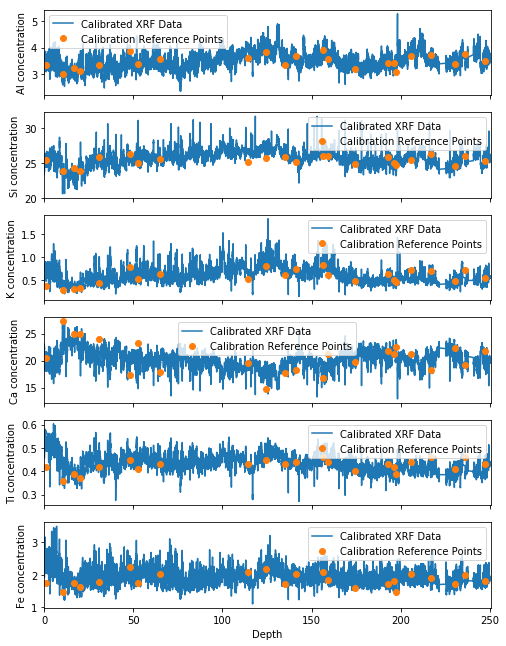

In [61]:
fig,ax=plt.subplots(nrows=6,figsize=(8,11),sharex=True)
for i,e in enumerate(['Al','Si','K','Ca','Ti','Fe']):
    nconcentrations_xrf[e].plot(ax=ax[i],label='Calibrated XRF Data')
    reference_conc[e].plot(ax=ax[i],ls='',marker='o',label='Calibration Reference Points')
    ax[i].legend()
    ax[i].set_ylabel(e+' concentration')

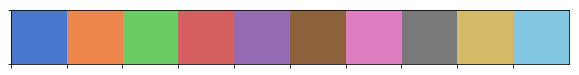

In [62]:
colors=sns.color_palette('muted',10)
sns.palplot(colors)

In [63]:
CaCO3['xrf_Ca']=nconcentrations_xrf.reindex(CaCO3.index,method='nearest')['Ca']
CaCO3['coul_Ca']=CaCO3['CaCO3']*.4

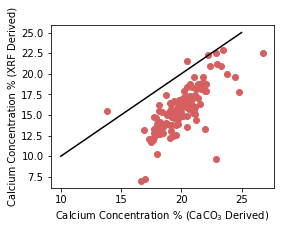

In [64]:
fig,ax=plt.subplots(figsize=(4,3))
ax.scatter(CaCO3['xrf_Ca'].loc[:248],CaCO3['coul_Ca'].loc[:248],color=colors[3])
ax.plot([10,25],[10,25],color='k')
ax.set_ylabel('Calcium Concentration % (XRF Derived)')
ax.set_xlabel('Calcium Concentration % (CaCO$_3$ Derived)')
fig.savefig(figure_path+'Ca.png',dpi=500)

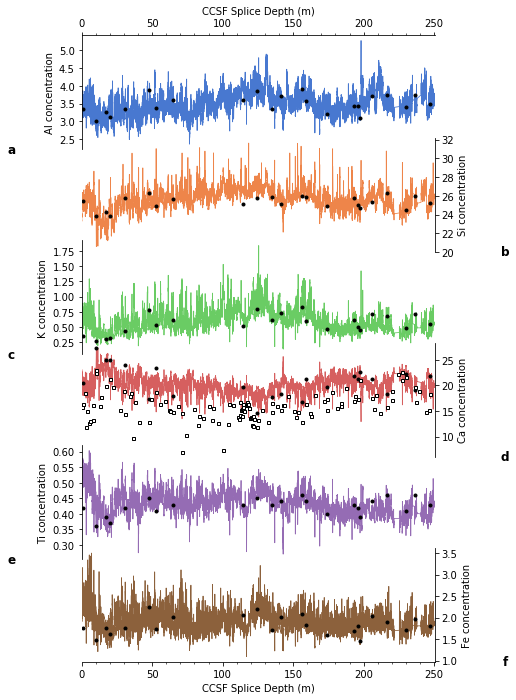

In [65]:
fig,axes=plt.subplots(nrows=6,figsize=(7,10))
sns.set_context('paper',font_scale=.8)

lw=.8
ms=1.5

sns.despine(ax=axes[0],right=True,bottom=True,top=False)
axes[0].patch.set_alpha(0)


for i,ax in enumerate(axes[1:-1]):
    if i%2==1:
        sns.despine(ax=ax,bottom=True)
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)
    else:
        sns.despine(ax=ax,left=True,bottom=True,right=False)
        ax.yaxis.set_label_position("right")
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)

axis=axes[-1]
if len(axes)%2==1:
    sns.despine(ax=axis)
    axis.patch.set_alpha(0)
else:
    sns.despine(ax=axis,left=True,right=False)
    axis.yaxis.set_label_position("right")
    axis.patch.set_alpha(0)
    
for i,e in enumerate(['Al','Si','K','Ca','Ti','Fe']):
    nconcentrations_xrf[e].plot(ax=axes[i],color=colors[i],lw=lw)
    reference_conc[e].plot(ax=axes[i],ls='',marker='o',color='k',
                                       markeredgecolor='k',markeredgewidth=1,ms=2*ms)
    axes[i].set_ylabel(e+' concentration')

(CaCO3['CaCO3']*.4).loc[0:248].plot(ax=axes[3],marker='s',ls='',color='white',markeredgecolor='k',ms=2*ms)

axes[0].annotate('a',xy=(-.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[1].annotate('b',xy=(1+.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[2].annotate('c',xy=(-.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[3].annotate('d',xy=(1+.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[4].annotate('e',xy=(-.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[5].annotate('f',xy=(1+.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')

axes[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axes[0].xaxis.set_label_position("top")
axes[0].set_xlabel('CCSF Splice Depth (m)')
axis=axes[-1]
axis.xaxis.set_minor_locator(AutoMinorLocator(5))
axis.set_xlabel('CCSF Splice Depth (m)')
    
plt.subplots_adjust(hspace=-.1,top=.94,bottom=.07,right=.85,left=.15)
fig.savefig(figure_path+'concentrations_depth.png',dpi=500)

### Export

In [66]:
nconcentrations_xrf.to_csv(table_path+'xrf_calibrated_concentrations_2mm_resolution.csv')
nconcentrations_xrf[::10].to_csv(table_path+'xrf_calibrated_concentrations_2cm_resolution.csv')

## Compare final data

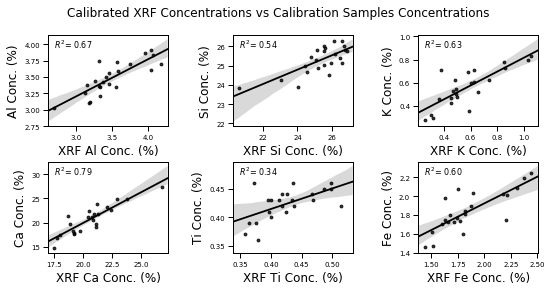

In [67]:
cts_check=pd.DataFrame(columns=reference_conc.columns)
xrf_check=nconcentrations_xrf
for i in reference_conc.index:
    idx=xrf_check.index.get_loc(i,method='nearest')
    cts_check.loc[xrf_check.iloc[idx].name]=xrf_check.iloc[idx]
fig,axes=plt.subplots(ncols=3,nrows=2,figsize=(8,4))
for i,col in enumerate(reference_conc.columns):
    ax=plt.subplot(2,3,i+1)
    sns.regplot(cts_check[col],reference_conc[col],color='k',ax=ax,scatter_kws={'s':8})
    text=str('$R^2$= '+r2(cts_check[col],reference_conc[col]).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel(col+' Conc. (%)',size=12)
    ax.set_xlabel('XRF '+col+' Conc. (%)',size=12)
plt.suptitle('Calibrated XRF Concentrations vs Calibration Samples Concentrations',size=12)
plt.subplots_adjust(hspace=.4,wspace=.55,right=.95,left=.1)
fig.savefig(figure_path+'5calibrated_xrf_vs_calibration.png',dpi=500)